In [214]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
import warnings

warnings.filterwarnings('ignore')

In [215]:
data = pd.read_csv('data/train.csv')
df_immo = data.copy()

df_immo.columns = [x.lower() for x in df_immo.columns]

# Remplacement des valeurs manquantes 
df_immo['garagetype'] = df_immo['garagetype'].fillna('NaN')
df_immo['garageyrblt'] = df_immo['garageyrblt'].fillna(0)
df_immo['garagefinish'] = df_immo['garagefinish'].fillna('NaN')
df_immo['garagequal'] = df_immo['garagequal'].fillna('NaN')
df_immo['garagecond'] = df_immo['garagecond'].fillna('NaN')
df_immo['bsmtqual'] = df_immo['bsmtqual'].fillna('NaN')
df_immo['bsmtcond'] = df_immo['bsmtcond'].fillna('NaN')
df_immo['bsmtexposure'] = df_immo['bsmtexposure'].fillna('NaN')
df_immo['bsmtfintype1'] = df_immo['bsmtfintype1'].fillna('NaN')
df_immo['bsmtfintype2'] = df_immo['bsmtfintype2'].fillna('NaN')
df_immo['masvnrtype'] = df_immo['masvnrtype'].fillna('NaN')
df_immo['masvnrarea'] = df_immo['masvnrarea'].fillna(0)
df_immo['lotfrontage'] = df_immo['lotfrontage'].fillna(0)
df_immo['fireplacequ'] = df_immo['fireplacequ'].fillna('NaN')

# Création de nouvelles colonnes afin de savoir si la maison possède une pisicne, une cheminée etc... 
df_immo['haspool'] = df_immo['poolarea'].apply(lambda x: 1 if x > 0 else 0)
df_immo['has2ndfloor'] = df_immo['2ndflrsf'].apply(lambda x : 1 if x > 0 else 0)
df_immo['hasgarage'] = df_immo['garagearea'].apply(lambda x: 1 if x > 0 else 0)
df_immo['hasbsmt'] = df_immo['totalbsmtsf'].apply(lambda x: 1 if x > 0 else 0)
df_immo['hasfireplace'] = df_immo['fireplaces'].apply(lambda x: 1 if x > 0 else 0)

def renovation(row):
    if row['yearbuilt'] != row['yearremodadd']:
        return 1
    else : 
        return 0

df_immo['renove'] = df_immo.apply(renovation, axis = 1)
df_immo = df_immo.drop(['poolarea', 'poolqc','alley','miscfeature','fence'], axis = 1)
df_immo


,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,yrsold,saletype,salecondition,saleprice,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,renove
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,2008,WD,Normal,208500,0,1,1,1,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,2007,WD,Normal,181500,0,0,1,1,1,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,2008,WD,Normal,223500,0,1,1,1,1,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,2006,WD,Abnorml,140000,0,1,1,1,1,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,2008,WD,Normal,250000,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,2007,WD,Normal,175000,0,1,1,1,1,1
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,210000,0,0,1,1,1,1
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,266500,0,1,1,1,1,1
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,142125,0,0,1,1,0,1


In [216]:
features_with_na=[features for features in df_immo.columns if df_immo[features].isnull().sum()>1]

for feature in features_with_na:
    print(f'{feature:-<30} : {np.round(df_immo[feature].isnull().sum(),4)}')
nombre_ligne = 'TOTAL LIGNE'
print(f'{nombre_ligne:-<30} : {len(df_immo.id)}')

TOTAL LIGNE------------------- : 1460


In [217]:
# df_immo = df_immo.drop(df_immo.loc[df_immo['salecondition']=='Family'].index, inplace = True)
# df_immo = df_immo.drop(df_immo[df_immo['mszoning']=='C (all)'].index, inplace = True)
index_salecondition_family = df_immo[ df_immo['salecondition'] == 'Family' ].index
df_immo.drop(index_salecondition_family , inplace=True)

df_immo

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,yrsold,saletype,salecondition,saleprice,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace,renove
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,2008,WD,Normal,208500,0,1,1,1,0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,2007,WD,Normal,181500,0,0,1,1,1,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,2008,WD,Normal,223500,0,1,1,1,1,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,2006,WD,Abnorml,140000,0,1,1,1,1,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,2008,WD,Normal,250000,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,2007,WD,Normal,175000,0,1,1,1,1,1
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,210000,0,0,1,1,1,1
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,266500,0,1,1,1,1,1
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,2010,WD,Normal,142125,0,0,1,1,0,1


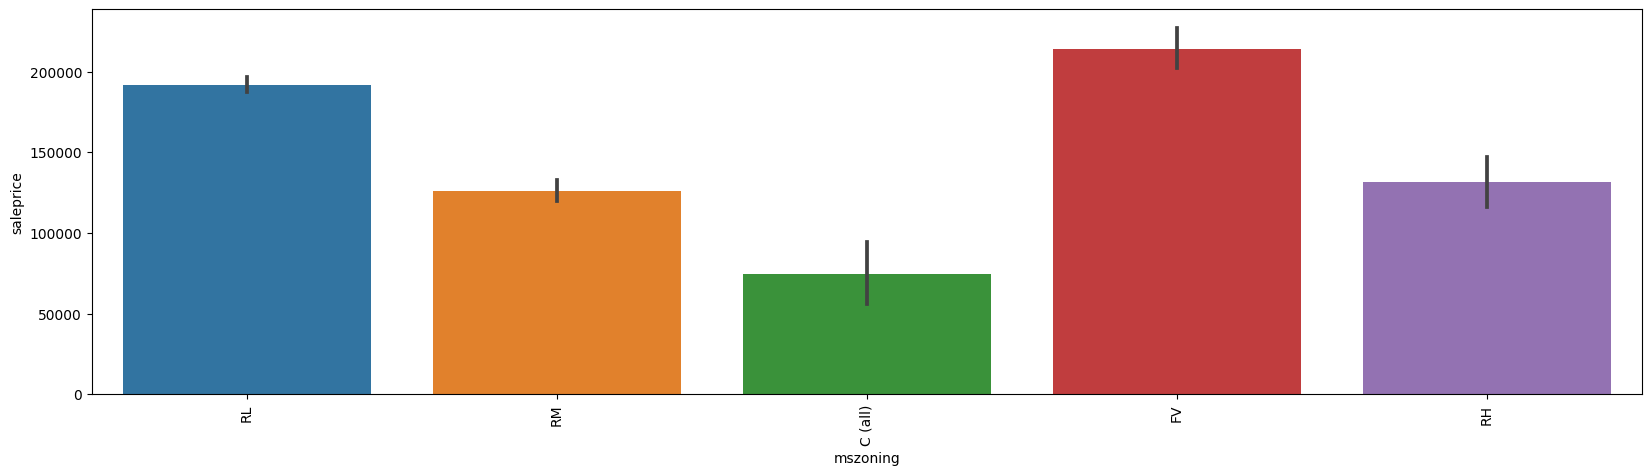

In [218]:
plt.subplots(figsize=(20,5))
sns.barplot(x=df_immo['mszoning'], y=df_immo['saleprice'])
plt.xticks(rotation=90)
plt.show()

In [219]:
index_mszoning_commercial = df_immo[ df_immo['mszoning'] == 'C (all)' ].index
df_immo.drop(index_mszoning_commercial, inplace=True)

df_immo['mszoning'].value_counts() 

RL    1137
RM     212
FV      65
RH      16
Name: mszoning, dtype: int64

In [220]:
def train_function(X, y, preprocessor):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

    list_sgd = {
        'sgd__penalty' : ['l1', 'l2', 'elasticnet'],
        'sgd__fit_intercept' : [False, True],
        'sgd__alpha' : [1, 10, 100, 1000, 10000],
        'sgd__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
    }
    
    list_gbr = {
        'gbr__loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'gbr__n_estimators' : [30, 70, 100, 150, 180],
        'gbr__subsample' : range(1, 21),    
    }

    list_knn = {
        'knn__n_neighbors' : range(0, 50, 5),
        'knn__leaf_size' : [10, 20, 30, 40, 50, 60],
        'knn__p' : range(0, 10),
    }

    list_svr = {
        'svr__tol' : [0.0001, 0.001, 0.01, 0.1, 1],
        'svr__fit_intercept' : [False, True],
        'svr__C' : [1, 10, 100, 1000],
    }

    list_rf = {
        'rf__n_estimators': range(20, 50, 5),
        'rf__criterion' : ["squared_error", "absolute_error", "poisson"], 
        'rf__max_depth': range(5, 20, 2),
        'rf__max_features': [5, 10, 15, 20],    
        }


    algo_list = [
        ('sgd', SGDRegressor(random_state=0)),
        ('gbr', GradientBoostingRegressor(random_state=0)),
        ('knn', KNeighborsRegressor()),
        ('svr', LinearSVR(random_state=0)),
        ('rf', RandomForestRegressor(random_state=0)), 
    ]

    list_param = [list_sgd, list_gbr, list_knn, list_svr, list_rf]
    metrics = ['MAE', 'RMSE', 'Median abs err', 'R2']
    list_mae = list()
    list_rmse = list()
    list_median = list()
    list_r2 = list()

    for algo, param in zip(algo_list, list_param): 
        model = Pipeline(steps=[("preprocessor",preprocessor), algo])
        grid = GridSearchCV(model, param)
        grid.fit(X_train, y_train)
        y_pred = grid.predict(X_test)

        print('_'*120)
        print(f'{algo[0]}')
        print(algo[0], grid.best_params_)

        mae_metric = mean_absolute_error(y_test, y_pred)
        rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred))
        median_metric = median_absolute_error(y_test, y_pred)
        R2_metric = grid.score(X_train,y_train)

        list_mae.append(mae_metric)
        list_rmse.append(rmse_metric)
        list_median.append(median_metric)
        list_r2.append(R2_metric)
        
        print(f'{metrics[0]:-<20} : {mae_metric}')
        print(f'{metrics[1]:-<20} : {rmse_metric}')
        print(f'{metrics[2]:-<20} : {median_metric}')
        print(f'{metrics[3]:-<20} : {R2_metric}')
        print('_'*120)

        err_hist = np.abs(y_test - y_pred)
        plt.hist(err_hist, bins = 50)
        plt.title(algo[0])
        plt.show()

        train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X_train, y_train, train_sizes = np.linspace(0.1, 1, 10))
        plt.plot(train_sizes,np.mean(train_scores, axis = 1), label = 'Train')
        plt.plot(train_sizes, np.mean(test_scores, axis = 1), label = 'Validation')
        plt.title('Learning-Curve')
        plt.legend()
        plt.show()  

    score_algo = pd.DataFrame({
        'Name' : [e[0] for e in algo_list],
        'MAE' : list_mae,
        'RMSE' : list_rmse,
        'Median abs err' : list_median,
        'R2' : list_r2, 
    })
    print(score_algo)

In [221]:
categories_gradues_features_type1 = ['garagecond','garagequal','kitchenqual','heatingqc','bsmtcond','bsmtqual','exterqual','extercond','fireplacequ']
categories_gradues_features_type2 = ['bsmtfintype1','bsmtfintype2',]

for i in categories_gradues_features_type1:
    df_immo[i] = df_immo[i].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NaN':0,'Na':0})

for j in categories_gradues_features_type2:
    df_immo[j] = df_immo[j].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NaN':0,'Na':0})

df_immo['lotshape'] = df_immo['lotshape'].map({'Reg':3,'IR1':2,'IR2':1,'IR3':0,'NaN':0})
df_immo['landcontour'] = df_immo['landcontour'].map({'Lvl':3,'Bnk':2,'HLS':1,'Low':0,'NaN':0})
df_immo['utilities'] = df_immo['utilities'].map({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0,'NaN':0})
df_immo['landslope'] = df_immo['landslope'].map({'Gtl':2,'Mod':1,'Sev':0,'NaN':0})
df_immo['bsmtexposure'] = df_immo['bsmtexposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NaN':0,'Na':0})
df_immo['centralair'] = df_immo['centralair'].map({'Y':1,'N':0,'NaN':0})
df_immo['garagefinish'] = df_immo['garagefinish'].map({'Fin':3,'RFn':2,'Unf':1,'Na':0,'NaN':0})

categories_features = ['mssubclass','mszoning','street','lotconfig','neighborhood','condition1','condition2','housestyle','roofstyle','roofmatl','exterior1st','exterior2nd',
'masvnrtype','foundation','heating','electrical','functional','garagetype','paveddrive','saletype','salecondition', 'bldgtype']

numeriques_features = make_column_selector(dtype_include=np.number)

In [222]:
for i in categories_features:
    le = LabelEncoder()
    le.fit(df_immo[i])
    ça = le.transform(df_immo[i])
    df_immo[i] = ça


numerical_pipeline = make_pipeline(StandardScaler())

In [223]:
preprocessor_numerobis = make_column_transformer((numerical_pipeline, numeriques_features))

X = df_immo.drop('saleprice', axis = 1)
y = df_immo['saleprice']

________________________________________________________________________________________________________________________
sgd
sgd {'sgd__alpha': 1, 'sgd__fit_intercept': True, 'sgd__penalty': 'elasticnet', 'sgd__tol': 0.0001}
MAE----------------- : 20639.005739177537
RMSE---------------- : 32236.684840965947
Median abs err------ : 14650.37101884911
R2------------------ : 0.7918163898474513
________________________________________________________________________________________________________________________


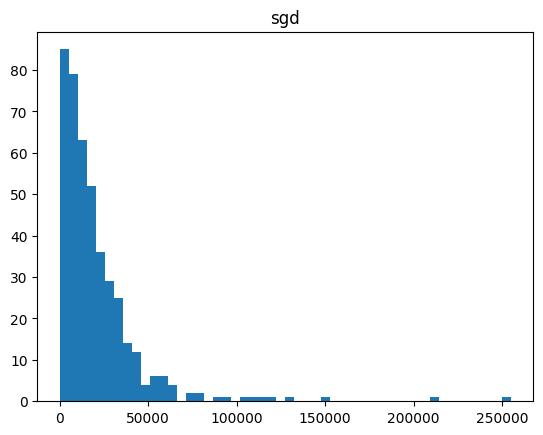

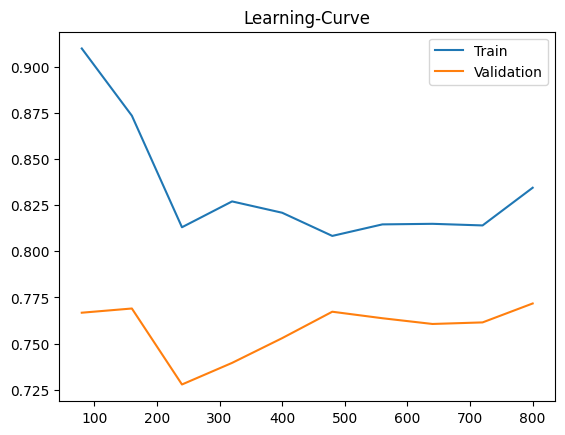

________________________________________________________________________________________________________________________
gbr
gbr {'gbr__loss': 'squared_error', 'gbr__n_estimators': 180, 'gbr__subsample': 1}
MAE----------------- : 15906.099656173268
RMSE---------------- : 28691.76051633105
Median abs err------ : 10733.501790415903
R2------------------ : 0.9860509037945117
________________________________________________________________________________________________________________________


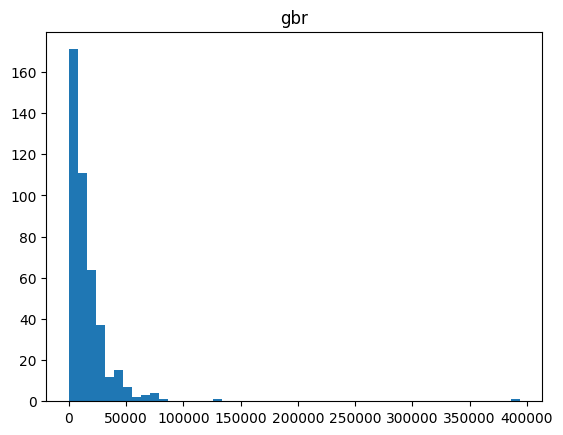

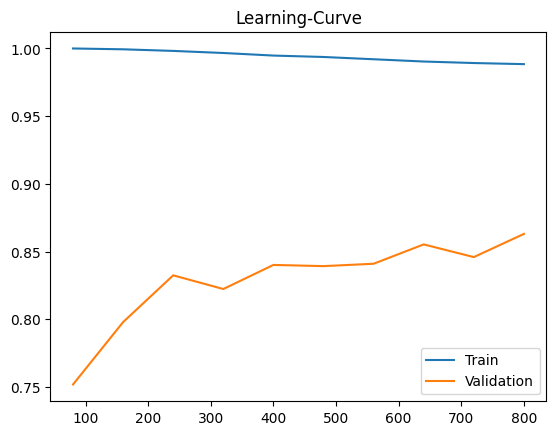

________________________________________________________________________________________________________________________
knn
knn {'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__p': 1}
MAE----------------- : 21910.592074592074
RMSE---------------- : 35837.084954951875
Median abs err------ : 13800.0
R2------------------ : 0.8751545052624774
________________________________________________________________________________________________________________________


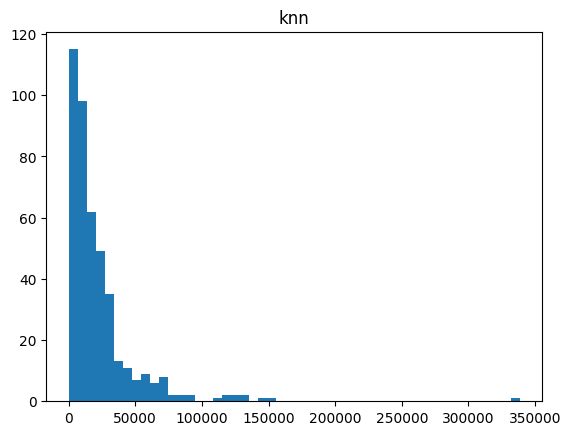

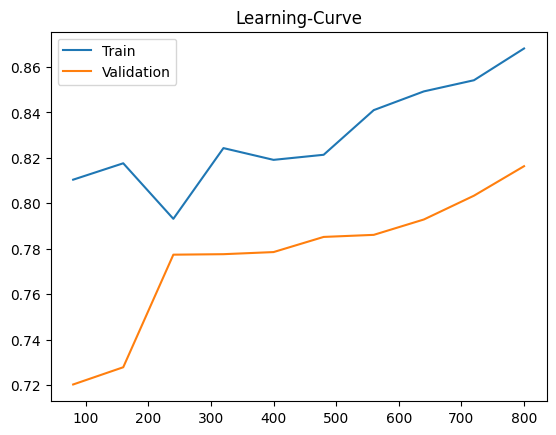

________________________________________________________________________________________________________________________
svr
svr {'svr__C': 1000, 'svr__fit_intercept': True, 'svr__tol': 0.001}
MAE----------------- : 18336.76285947143
RMSE---------------- : 30924.142822407724
Median abs err------ : 12380.657468907099
R2------------------ : 0.8187126640261053
________________________________________________________________________________________________________________________


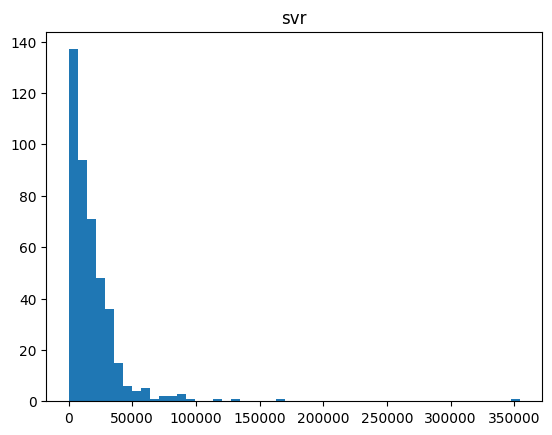

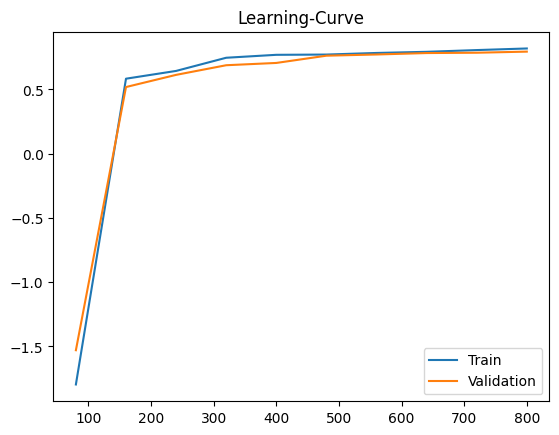

________________________________________________________________________________________________________________________
rf
rf {'rf__criterion': 'squared_error', 'rf__max_depth': 11, 'rf__max_features': 20, 'rf__n_estimators': 30}
MAE----------------- : 16479.814689850424
RMSE---------------- : 28540.626895873
Median abs err------ : 11210.585784694616
R2------------------ : 0.9745010854142979
________________________________________________________________________________________________________________________


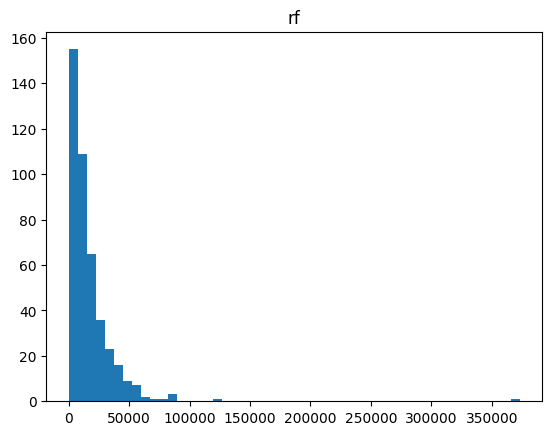

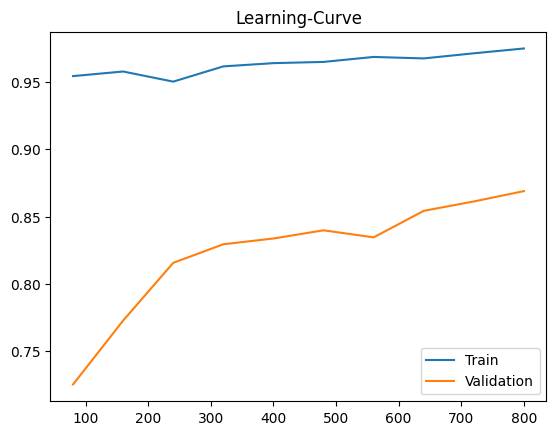

  Name           MAE          RMSE  Median abs err        R2
0  sgd  20639.005739  32236.684841    14650.371019  0.791816
1  gbr  15906.099656  28691.760516    10733.501790  0.986051
2  knn  21910.592075  35837.084955    13800.000000  0.875155
3  svr  18336.762859  30924.142822    12380.657469  0.818713
4   rf  16479.814690  28540.626896    11210.585785  0.974501


In [224]:
train_function(X, y, preprocessor_numerobis)

En supprimant, les valeurs 'c' de la feature 'mszoning' nous avons supprimé des valeurs que nous pouvions qualifier d'outliers, puisqu'elles étaient présentes en quantiés très faible et que leur prix etaient inférieurs à la moyenne. Ainsi, la RMSE est plus base qu'avant mais notre score R2 lui, est plus faible.  

Les learnings curves nous montrent que les algorithmes (sauf SVR) ont besions de plus de données pour leur apprentissage, particulièrement Knn et RandomForest.

# Choix des vingts features les plus cohérentes : 

In [225]:
# On utilise les features importantes trouver dans le premier notebook. 
importantes_features = ['overallqual', 'grlivarea', 'totalbsmtsf','bsmtfinsf1', '1stflrsf', 'garagecars', 'garagearea', 'lotarea', 'yearbuilt', 'masvnrarea','yearremodadd','totrmsabvgrd' ,'fullbath', 'saleprice']
df_immo_bis = df_immo[importantes_features]
df_immo_bis

,overallqual,grlivarea,totalbsmtsf,bsmtfinsf1,1stflrsf,garagecars,garagearea,lotarea,yearbuilt,masvnrarea,yearremodadd,totrmsabvgrd,fullbath,saleprice
0,7,1710,856,706,856,2,548,8450,2003,196.0,2003,8,2,208500
1,6,1262,1262,978,1262,2,460,9600,1976,0.0,1976,6,2,181500
2,7,1786,920,486,920,2,608,11250,2001,162.0,2002,6,2,223500
3,7,1717,756,216,961,3,642,9550,1915,0.0,1970,7,1,140000
4,8,2198,1145,655,1145,3,836,14260,2000,350.0,2000,9,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,953,0,953,2,460,7917,1999,0.0,2000,7,2,175000
1456,6,2073,1542,790,2073,2,500,13175,1978,119.0,1988,7,2,210000
1457,7,2340,1152,275,1188,1,252,9042,1941,0.0,2006,9,2,266500
1458,5,1078,1078,49,1078,1,240,9717,1950,0.0,1996,5,1,142125


In [226]:
features_with_na=[features for features in df_immo_bis.columns if df_immo_bis[features].isnull().sum()>1]

for feature in features_with_na:
    print(f'{feature:-<30} : {np.round(df_immo_bis[feature].isnull().sum(),4)}')
nombre_ligne = 'TOTAL LIGNE'


In [227]:
X1 = df_immo_bis.drop('saleprice', axis = 1)
y1 = df_immo_bis['saleprice']

________________________________________________________________________________________________________________________
sgd
sgd {'sgd__alpha': 1, 'sgd__fit_intercept': True, 'sgd__penalty': 'elasticnet', 'sgd__tol': 0.0001}
MAE----------------- : 22124.47673663735
RMSE---------------- : 34918.93219995373
Median abs err------ : 13500.027101072017
R2------------------ : 0.7544791781430573
________________________________________________________________________________________________________________________


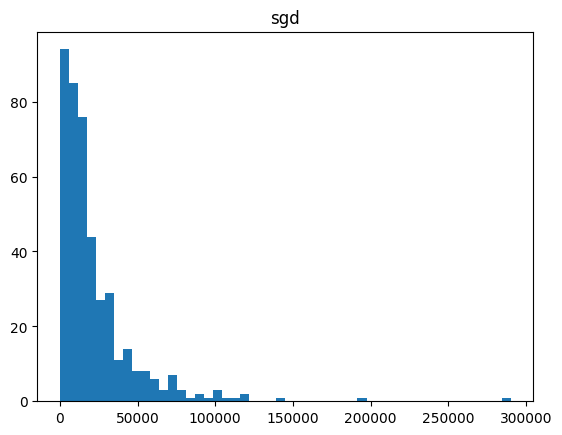

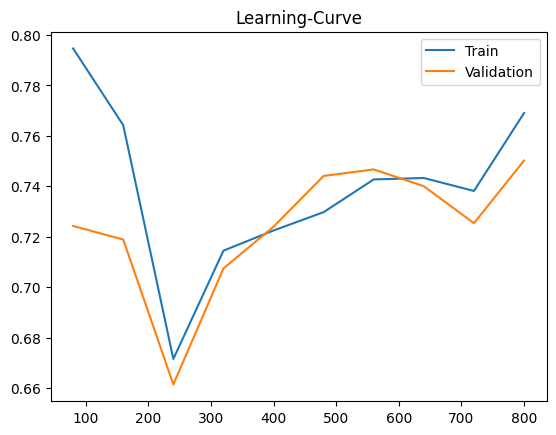

________________________________________________________________________________________________________________________
gbr
gbr {'gbr__loss': 'squared_error', 'gbr__n_estimators': 180, 'gbr__subsample': 1}
MAE----------------- : 17053.903900130477
RMSE---------------- : 31830.367573054664
Median abs err------ : 10515.96193305729
R2------------------ : 0.9767169228224784
________________________________________________________________________________________________________________________


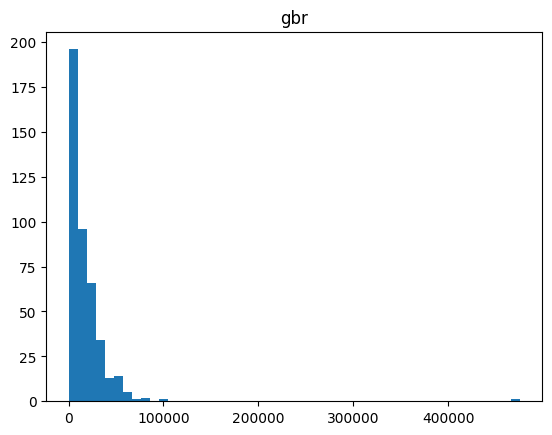

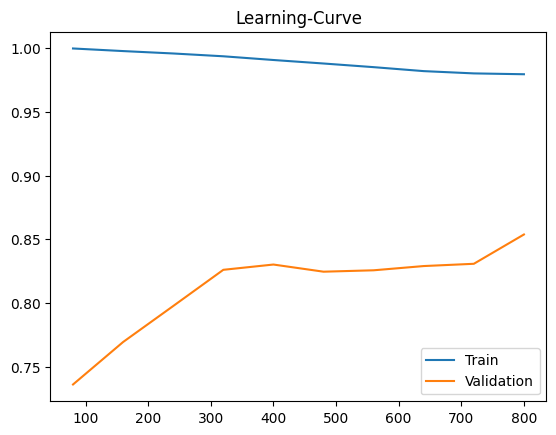

________________________________________________________________________________________________________________________
knn
knn {'knn__leaf_size': 60, 'knn__n_neighbors': 5, 'knn__p': 1}
MAE----------------- : 20334.00839160839
RMSE---------------- : 35372.87283679164
Median abs err------ : 12120.0
R2------------------ : 0.8900706462893198
________________________________________________________________________________________________________________________


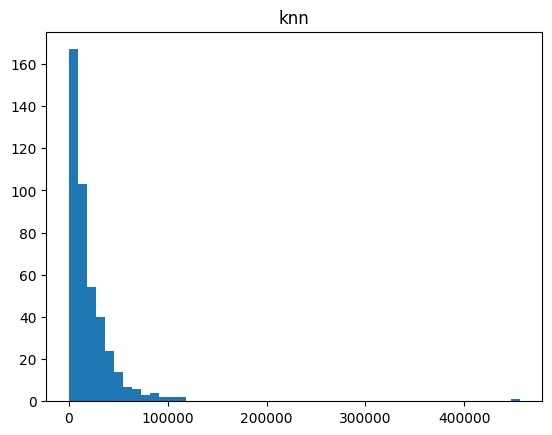

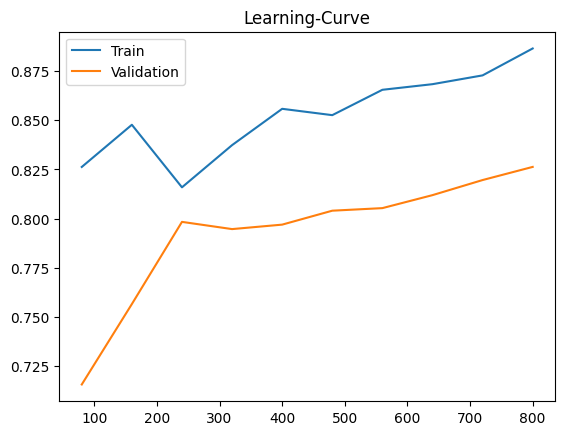

________________________________________________________________________________________________________________________
svr
svr {'svr__C': 1000, 'svr__fit_intercept': True, 'svr__tol': 0.1}
MAE----------------- : 20653.36964015106
RMSE---------------- : 33864.41513291018
Median abs err------ : 12822.929167890863
R2------------------ : 0.7588750912794271
________________________________________________________________________________________________________________________


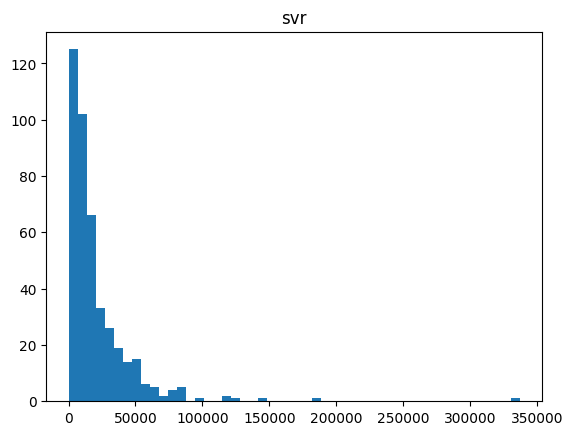

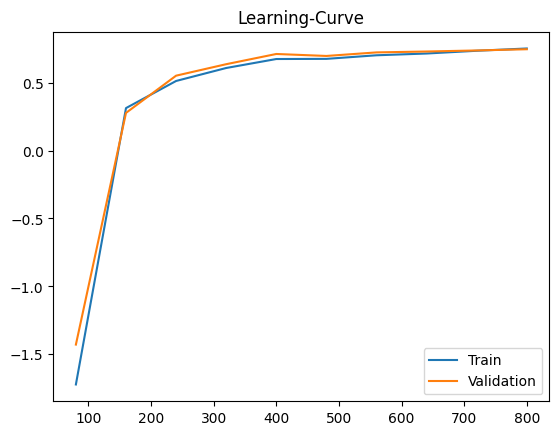

________________________________________________________________________________________________________________________
rf
rf {'rf__criterion': 'poisson', 'rf__max_depth': 9, 'rf__max_features': 5, 'rf__n_estimators': 20}
MAE----------------- : 17689.75880294715
RMSE---------------- : 32824.337061150436
Median abs err------ : 11396.526224059577
R2------------------ : 0.9668087796945439
________________________________________________________________________________________________________________________


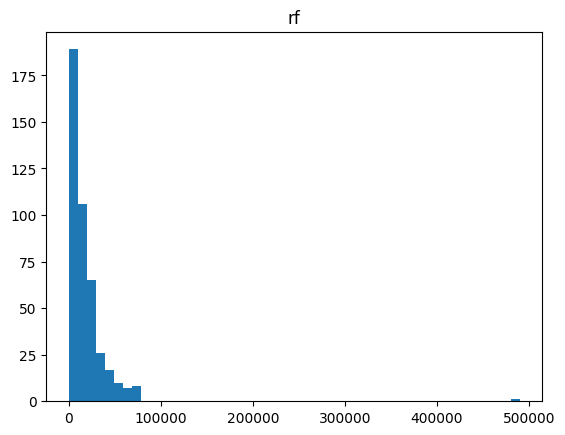

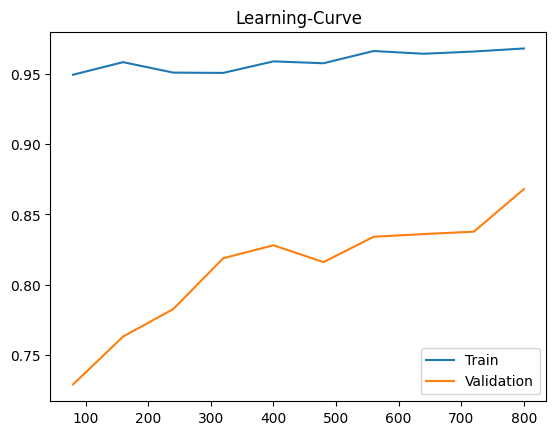

  Name           MAE          RMSE  Median abs err        R2
0  sgd  22124.476737  34918.932200    13500.027101  0.754479
1  gbr  17053.903900  31830.367573    10515.961933  0.976717
2  knn  20334.008392  35372.872837    12120.000000  0.890071
3  svr  20653.369640  33864.415133    12822.929168  0.758875
4   rf  17689.758803  32824.337061    11396.526224  0.966809


In [228]:
train_function(X1, y1, preprocessor_numerobis)

# SGD : 

Les scores sont moins bons, surtout le R2, ce qui signifie que SGD préfère avoir un grand nombre de features en entré. La courbe d'apprentissage nous montre que nous manquons de données. 

# GBR : 

Les scores MAE, RMSE et R2 sont légèrement moins bon qu'avec un grand nombre de features mais le score median est légèrement meilleur. La courbe d'apprentissage nous montre qu nous manquons de données. 

# knn : 

C'est celui à qui le tri des données à le plus profité, tous les scores se sont améliorés. De même, la learning curve nous indique que nous manquons de données. 

# SVR : 

Tous ses scores sont en baisse, et sa learning cruve est plate, donc nous ne pourrons pas obtenir de meilleurs scores.

# rf : 

Les scores de cet algorithme sont en légère baisse mais sa learning curve nous indique que nous manquons de données pour avoir un modèle optimum. 